In [1]:
pip install torch torchvision torchaudio


Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install spotipy

Note: you may need to restart the kernel to use updated packages.


In [3]:
#CLIENT_ID=e1552059480f49f989a5a143bf1aa6df
#CLIENT_SECRET = ae6e1eb41c884e4b868e1c7125f1c5e1

/var/folders/m9/r_xrfyxx2fd0lfyv07vvh8s00000gn/T/ipykernel_2338/4084758996.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping triggered.
Epoch 16/80 | Train Loss: 1.0299 | Val Loss: 1.0818 | Train Acc: 0.5909 | Val Acc: 0.5699

Test Accuracy: 48.93%


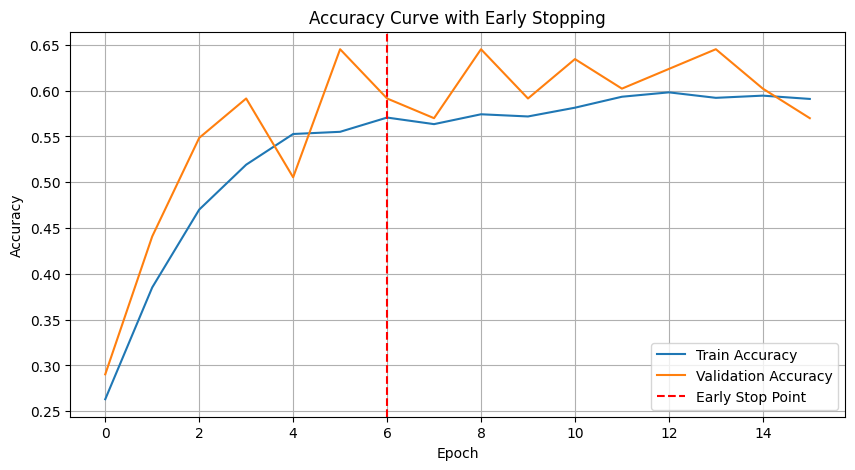

In [1]:
import torch 
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader, WeightedRandomSampler
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials





# Lists to store metrics including early stopping metrics
train_loss_list = []
val_loss_list = []

train_acc_list = []
val_acc_list = []

#initial read of data
df_tracks = pd.read_csv("high_popularity_spotify_data.csv")


#features to be used
features = ["energy", "tempo", "danceability", "loudness",
                     "liveness", "valence", "time_signature",
                    "speechiness", "acousticness", "instrumentalness", "key"]


target_genres = [
    "pop", "ambient", "classical", "electronic", 
    "folk", "country", "soul", "hip-hop", "jazz", "metal", "rock", "punk"
]

#code to read in only the correct genres and to combine certain genres to match Oliver's data
df_tracks = df_tracks[df_tracks["playlist_genre"].isin(target_genres)]

genre_map = {
    "metal" : "metal",
    "pop":"pop",
    "ambient": "ambient_chill",
    "classical": "classical_orchestral",
    "electronic": "electronic_edm",
    
    "folk" : "folk_country",
    "country" : "folk_country",
    
    "soul" : "funk_soul_rnb",
    "hip-hop" : "hip-hop", 
    "jazz": "jazz",
    
    "rock" : "rock_punk",
    "punk": "rock_punk"

}

df_tracks["playlist_genre"] = df_tracks["playlist_genre"].map(genre_map)
df_tracks = df_tracks.dropna(subset=["playlist_genre"])



X = df_tracks[features]
y = df_tracks["playlist_genre"]

#encoding labels and scaling. Very important to encode our genres as something the training can read, like an integer
label_encoder = LabelEncoder().fit(y)
y_encoded = label_encoder.transform(y)

#prevents certain features, such as loudness or tempo, from dominating the code
scaler = StandardScaler()
X = scaler.fit_transform(X)


#splits the dataset into training, validation and testing data
#training set updates parameters and validation set is used for early stopping
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#converts all data to tensors for torch
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_val   = torch.tensor(X_val, dtype=torch.float32).to(device)
X_test  = torch.tensor(X_test, dtype=torch.float32).to(device)

y_train = torch.tensor(y_train, dtype=torch.long).to(device)
y_val   = torch.tensor(y_val, dtype=torch.long).to(device)
y_test  = torch.tensor(y_test, dtype=torch.long).to(device)



#creates a pyTorch database and dataloader
#does batching and splits the dataset into chunks of 64 and shuffles for more efficient iteration
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


#defines our MLP model with our 11 features and our three hidden layers - a 256 to 128 to 64 output
#dropout helps regularize and ReLU introduces nonlinearity
input_size = X_train.shape[1]
class MLP(nn.Module):
    def __init__(self, input_size, num_classes=None):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Linear(64, num_classes),
        
        )
    def forward(self, x):
        return self.net(x)

        
classes = label_encoder.classes_
num_features = X_train.shape[1]
num_classes = len(classes)
model = MLP(input_size=num_features, num_classes=num_classes).to(device)


#sets up loss, optimizer, and scheduler. 
#Adam updates model weights with backprop
#the scheduler is used to reduce learning rate if validation stops improving and to help escape plateaus
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, verbose=True
)


epochs = 80
best_val_acc = 0
patience = 10
patience_counter = 0

for epoch in range(epochs):
    model.train()
    running_loss = 0

    correct = 0
    total = 0

    #xb is training samples. yb is corresponding labels
    for xb, yb in train_loader:
        optimizer.zero_grad()
        #batch is passed through MLP
        out = model(xb)
        #measures accuracy of predictions
        loss = criterion(out, yb)
        #computes gradients of weights. Compares with loss
        loss.backward()
        #updates parameters
        optimizer.step()

        

        #accumulates metrics to count correct predictions
        running_loss += loss.item() * xb.size(0)


        preds = out.argmax(1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)
 
    #computes final metrics
    train_loss = running_loss / len(train_loader.dataset)

    train_acc = correct / total
    

    # Validation. DOES NOT update weights. Just evaluates performance
    model.eval()
    with torch.no_grad():
        val_out = model(X_val)
        val_loss = criterion(val_out, y_val).item()
        val_pred = val_out.argmax(1)
        val_acc = (val_pred == y_val).float().mean().item()

    scheduler.step(val_loss)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    
    #early stopping logic if accuracy does not improve over 10 epochs
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")

            break
  

print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
          f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")


#loads the best model, not the model we stopped on with early stopping
model.load_state_dict(torch.load("best_model.pt"))
model.eval()
with torch.no_grad():
    preds = model(X_test)
    predicted = preds.argmax(dim=1)
    acc = (predicted == y_test).float().mean()

    print(f"\nTest Accuracy: {acc.item()*100:.2f}%")

predicted_genres = label_encoder.inverse_transform(predicted.cpu().numpy())

y_true = y_test.cpu().numpy()
y_pred = predicted.cpu().numpy()




#plots learning curves
plt.figure(figsize=(10,5))
plt.plot(train_acc_list, label="Train Accuracy")
plt.plot(val_acc_list, label="Validation Accuracy")
plt.axvline(len(val_acc_list)-patience_counter,
            color='r', linestyle='--', label='Early Stop Point')

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve with Early Stopping")
plt.legend()
plt.grid(True)
plt.show()



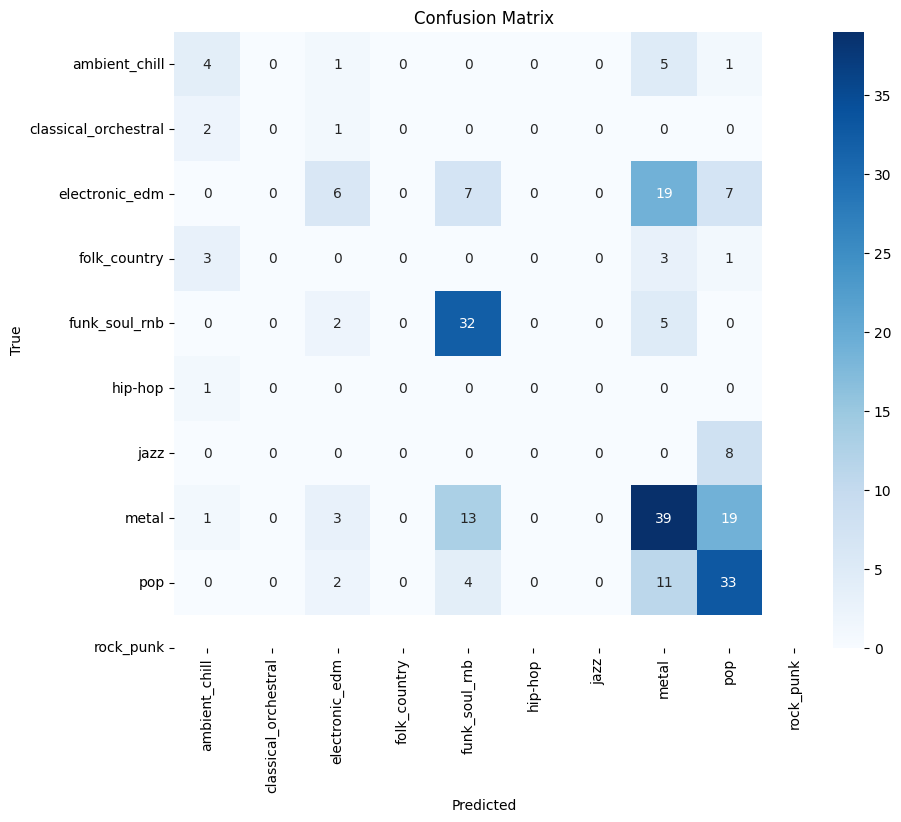

In [2]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [6]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth

sp_oauth = SpotifyOAuth(
    client_id="dabaa2ec51a645419468085e6caefca9",
    client_secret="cfd1040891434d92b0488cf4d85ff86f",
    redirect_uri="http://127.0.0.1:3000",
    scope="user-library-read"
)

auth_url = sp_oauth.get_authorize_url()
print("Go to this URL and authorize the app:", auth_url)

Go to this URL and authorize the app: https://accounts.spotify.com/authorize?client_id=dabaa2ec51a645419468085e6caefca9&response_type=code&redirect_uri=http%3A%2F%2F127.0.0.1%3A3000&scope=user-library-read
